# ¿Cuántas órdenes hay por código postal?

## Parámetros

In [1]:
BASE_DIR = '/Users/efraflores/Desktop/EF/Corner/Requests/Orders_by_zipcode'
SHP_FOLDER = 'SHP_folder'
CSV_FILE = 'Orders_CDMX_nov-test.csv'

## Código

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

from pandas import read_csv
from geopandas import GeoDataFrame, GeoSeries, read_file, points_from_xy, sjoin

class OrdersByZipcode:
    def __init__(self, base_dir: str, shp_file: str, csv_file: str) -> None:
        self.base_dir = Path(base_dir)
        self.shp_path = self.base_dir.joinpath(shp_file)
        self.csv_path = self.base_dir.joinpath(csv_file)

    def merge_files(self, lat_col: str, lng_col: str) -> None:
        self.shp = read_file(self.shp_path).to_crs(crs="+proj=longlat +datum=WGS84 +no_defs")
        df = read_csv(self.csv_path)
        df = GeoDataFrame(df, crs='EPSG:6372', geometry=points_from_xy(df[lng_col], df[lat_col], crs='EPSG:6372'))
        self.df = sjoin(self.shp, df)

    def group_by_polygon(self, id_col: str) -> GeoDataFrame:
        df = self.df.astype(str).groupby('geometry')['order_id'].count().reset_index()
        df = df.merge(self.shp.astype(str)).set_index(id_col)
        df['geometry'] = GeoSeries.from_wkt(df['geometry'])
        self.df = GeoDataFrame(df)

    def orders_heatmap(self, **kwargs) -> None:
        self.df.plot(**kwargs)
        plt.axis('off')
        plt.show()

    def full_pipeline(self, export_result: bool=True) -> GeoDataFrame:
        self.merge_files(lat_col='lat', lng_col='long')
        self.group_by_polygon(id_col='d_cp')
        self.orders_heatmap(column='order_id', cmap='coolwarm', legend=False)
        if export_result: self.df.to_csv(self.base_dir.joinpath('orders_by_zipcode.csv'))
        return self.df


## Transformar

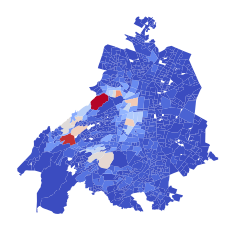

,geometry,order_id
d_cp,,
07950,"POLYGON ((-99.08346 19.47402, -99.08179 19.473...",29
14737,"POLYGON ((-99.23602 19.26992, -99.23599 19.270...",2
15620,"POLYGON ((-99.06723 19.44653, -99.06525 19.445...",1
07918,"POLYGON ((-99.07001 19.47429, -99.06999 19.474...",79


In [3]:
df = OrdersByZipcode(BASE_DIR, SHP_FOLDER, CSV_FILE).full_pipeline()
df.sample(4)